# Run "ETL" script

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

22/09/26 20:07:47 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.17.215.54 instead (on interface eth0)
22/09/26 20:07:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 20:07:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample.unionByName(transactions_sample2, True)
transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [3]:
merchants = merchants_tbl.toPandas()

In [4]:
import re
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [5]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [6]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [7]:
# This could be further expanded in breaking the discription up further

In [8]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [9]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [10]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

# Outlier detection algorithm
This will be inplemented by taking the 95% CI from the mean, and removing values which fall out of this coverage (more explanation below)

In [103]:
# use the SIQR range
# see https://towardsdatascience.com/outlier-detection-part-2-6839f6199768
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Second_percentile = F.expr('percentile_approx(dollar_value, 0.5)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'), Second_percentile.alias('2_val'), F.count('dollar_value').alias('Count'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Lower', F.col('2_val') - F.col('1_val'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Upper', F.col('3_val') - F.col('2_val'))
# Now calculate the limits
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 3 * F.col('SIQR_Upper'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 3 * F.col('SIQR_Lower'))
# after noticing that some merchants only have one transaction value (i.e one dollar_value amount for all transactios)
# decided to removed due to unrealisic distributed data 
quartile_dataset = quartile_dataset.withColumn('Natural_var', F.when((F.col('Upper_limit') == F.col('Lower_limit')) & (F.col('Count') > 10), True).otherwise(False))
quartile_dataset = quartile_dataset.select('merchant_abn', 'Upper_limit', 'Lower_limit', 'Natural_var')

In [104]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [105]:
# finally identify the outliers which fall out of distribution or apart of a dodgy business
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')) & (F.col('Natural_var') == False), False)
                                              .otherwise(True))

In [106]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

108528

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

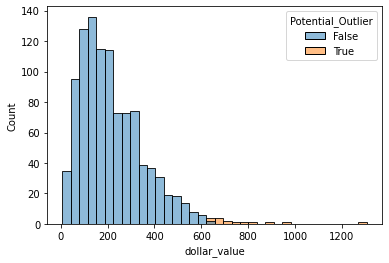

In [107]:
import seaborn as sns
sns.histplot(x='dollar_value', hue = 'Potential_Outlier', data=full_quantile.where(full_quantile.merchant_abn == 10023283211).select('dollar_value', 'Potential_Outlier').toPandas())